### Задача регрессии, или как у меня времени на генерацию не хватило
Взял [dataset](https://github.com/itmo-ml-lab-ML-course/parser-Dforgeek) первой лабы 

In [1]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
import torch
from torch.utils.data import Dataset, DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/hotel-data/hotel_data.csv").convert_dtypes()
df.head()

,Hotel Name,Is Top Stays,Center Distance,Metro Distance,Price,Rating,Number of Reviews,Description,Индивидуальная регистрация заезда и отъезда,Компьютер,...,Упакованные ланчи,Бесплатный Wi-Fi,Доступ в интернет,Трансфер,Трансфер от аэропорта,Персонал говорит на английском,Персонал говорит на русском,Парковка,Размещение подходит для семей/детей,Размещение с домашними животными не допускается
0,Апартаменты Премиум на Стрелке Васильевского,True,1.4,0.605,6800,9.9,12,"Выбор туристов, которые хотят везде чувствоват...",True,False,...,False,True,False,False,False,False,False,True,True,False
1,Апартаменты Антресоль,True,1.7,0.415,2300,9.3,89,Подходящий вариант для большой компании: апарт...,False,False,...,False,False,True,False,False,False,False,True,False,True
2,Апартаменты 15 комнат Петербургская квартира,True,2.5,0.281,1800,8.4,41,Залог хорошего отдыха — чувствовать себя в нов...,False,False,...,False,False,True,False,False,False,False,False,True,False
3,Апартаменты Art Mayak,True,2.2,0.797,10400,10.0,7,Апартаменты «Art Mayak» расположены в Санкт-Пе...,True,False,...,False,True,False,False,False,False,False,True,True,True
4,Отель ARTSTUDIO Nevsky,True,2.9,0.355,5600,8.5,187,Отель бизнес-класса «ARTSTUDIO Nevsky» располо...,True,False,...,False,True,False,True,True,False,False,True,True,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12619 entries, 0 to 12618
Data columns (total 51 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Hotel Name                                       12619 non-null  string 
 1   Is Top Stays                                     12619 non-null  boolean
 2   Center Distance                                  12619 non-null  Float64
 3   Metro Distance                                   12619 non-null  Float64
 4   Price                                            12604 non-null  Int64  
 5   Rating                                           6498 non-null   Float64
 6   Number of Reviews                                6313 non-null   Int64  
 7   Description                                      12517 non-null  string 
 8   Индивидуальная регистрация заезда и отъезда      12619 non-null  boolean
 9   Компьютер                   

Предобработка из третьей лабы числовых признаков

In [4]:
df['Description'] = df['Description'].fillna("Нет описания")

df.columns = df.columns.str.replace(' ', '_')
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)
df = df.dropna(subset=['Price'])
df = df.fillna(0)

In [5]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]
percentage_outliers = (len(outliers) / len(df)) * 100
df = df[df['Price'] <= upper_bound]

lower_bound, upper_bound, len(outliers), percentage_outliers

(0.0, 8000.0, 677, 5.3713106950174545)

In [6]:
df['Rural_Hotel'] = df['Center_Distance'].apply(lambda x: 1 if x > 12.5 else 0)
df['Unpopular'] = (df['Number_of_Reviews'] < 3).astype(int)


### Анализ

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


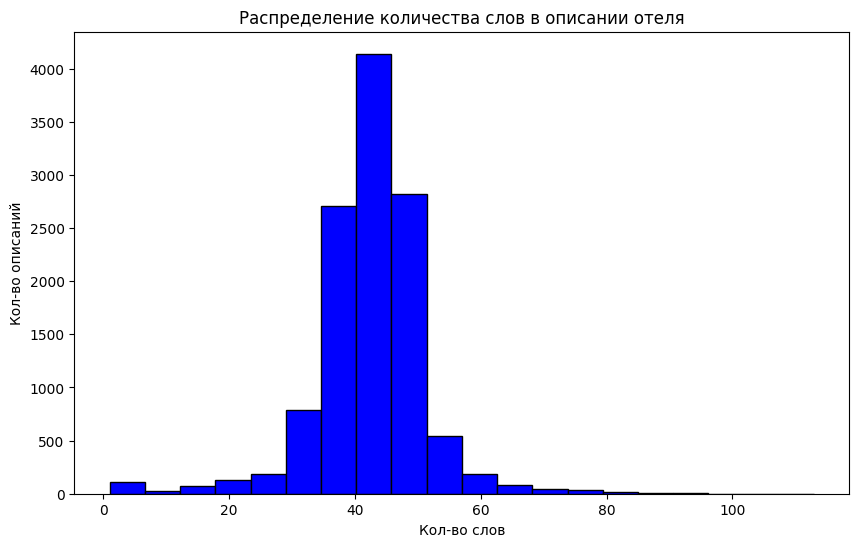

Среднее кол-во слов: 42.42231910790643
Среднее кол-во символов: 257.49073530644756
Частые слова: [('апартаменты', 18508), ('города', 11390), ('рядом', 11118), ('центра', 10696), ('км', 8286), ('находятся', 7397), ('неподалёку', 6766), ('апартаментами', 6749), ('прогуляться', 5421), ('отель', 4505), ('находится', 4242), ('расположены', 3812), ('располагаются', 3610), ('дома', 3063), ('чувствовать', 2712), ('выбор', 2708), ('туристов', 2696), ('площадь', 2696), ('собор', 2689), ('вариант', 2615), ('отдыха', 2499), ('лавра', 2308), ('улица', 2291), ('зодчего', 2161), ('росси', 2161), ('театр', 2134), ('расположен', 2112), ('мариинский', 2103), ('располагается', 1940), ('отелем', 1886), ('подходящий', 1822), ('проспект', 1810), ('петропавловская', 1791), ('крепость', 1789), ('казанский', 1751), ('доступности', 1657), ('компании', 1633), ('сад', 1509), ('пешей', 1496), ('новом', 1390), ('которые', 1370), ('хотят', 1368), ('везде', 1368), ('месте', 1353), ('большой', 1346), ('залог', 1344), 

In [7]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('russian'))
df['word_count'] = df['Description'].apply(lambda x: len(word_tokenize(x)))
df['char_count'] = df['Description'].apply(len)

all_words = ' '.join(df['Description']).lower()
tokens = word_tokenize(all_words)
tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
frequency = Counter(tokens)

plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=20, color='blue', edgecolor='black')
plt.title('Распределение количества слов в описании отеля')
plt.xlabel('Кол-во слов')
plt.ylabel('Кол-во описаний')
plt.show()

print("Среднее кол-во слов:", df['word_count'].mean())
print("Среднее кол-во символов:", df['char_count'].mean())
print("Частые слова:", frequency.most_common(50))

##### Это всё, конечно, очень круто. Только фактически действительно важно понимать сейчас - сколько у меня есть токенов в каждом примере. ruBERT, если я ничего не путаю, ограничен контекстом в 512 токенов. Было бы неприятно выходить за этот предел.

In [8]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

In [9]:

def count_bert_tokens(text):
    bert_tokens = tokenizer.tokenize(text)
    return len(bert_tokens)


df['bert_token_count'] = df['Description'].apply(lambda x: len(tokenizer.tokenize(x)))


Max tokens: 146
Mean tokens: 53.85293871048881


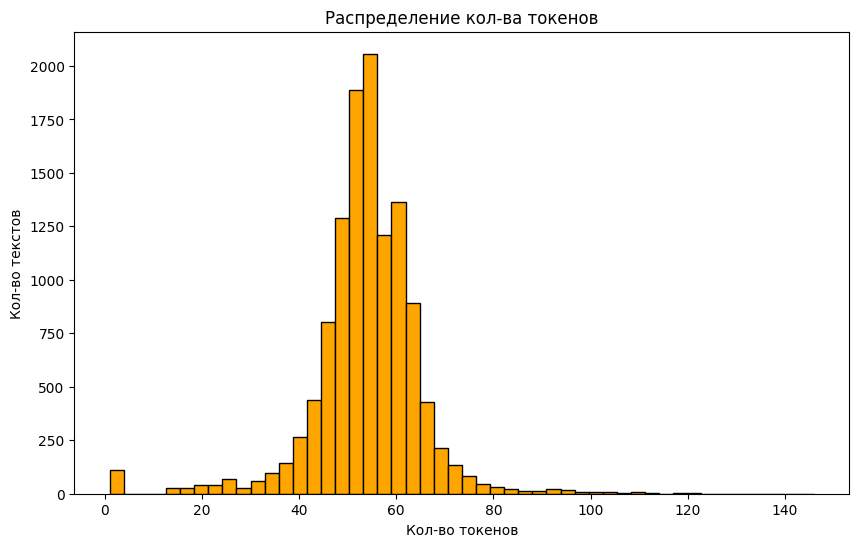

In [10]:
print("Max tokens:", df['bert_token_count'].max())
print("Mean tokens:", df['bert_token_count'].mean())
plt.figure(figsize=(10, 6))
plt.hist(df['bert_token_count'], bins=50, color='orange', edgecolor='black')
plt.title('Распределение кол-ва токенов')
plt.xlabel('Кол-во токенов')
plt.ylabel('Кол-во текстов')
plt.show()


Нормально, берта нам за глаза.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11927 entries, 0 to 12618
Data columns (total 56 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Hotel_Name                                       11927 non-null  string 
 1   Is_Top_Stays                                     11927 non-null  int64  
 2   Center_Distance                                  11927 non-null  Float64
 3   Metro_Distance                                   11927 non-null  Float64
 4   Price                                            11927 non-null  Int64  
 5   Rating                                           11927 non-null  Float64
 6   Number_of_Reviews                                11927 non-null  Int64  
 7   Description                                      11927 non-null  string 
 8   Индивидуальная_регистрация_заезда_и_отъезда      11927 non-null  int64  
 9   Компьютер                        

### Скейлинг таргета

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['Price'] = scaler.fit_transform(df[['Price']])

#### Создание Dataset

In [13]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


class HotelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=170):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.target = dataframe['Price']
        self.numeric_features = dataframe.drop(columns=['Description', 'Hotel_Name', 'Price'])
        self.max_len = max_len

        self.text = dataframe['Description']
        self.text_token_ids = []
        self.attention_masks = []

        for t in self.text:
            encoded = tokenizer.encode_plus(
                t,
                add_special_tokens=True,
                max_length=max_len,
                padding='max_length',
                return_attention_mask=True,
                truncation=True,
                return_tensors='pt'
            )
            self.text_token_ids.append(encoded['input_ids'])
            self.attention_masks.append(encoded['attention_mask'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        return {
            "ids": self.text_token_ids[index].squeeze(0),
            "attention_masks": self.attention_masks[index].squeeze(0),
            "numeric_features": torch.tensor(self.numeric_features.iloc[index].values, dtype=torch.float32),
            "target": torch.tensor(self.target.iloc[index], dtype=torch.float32)
        }

    def get_numeric_features_count(self):
        return len(self.numeric_features.columns)


train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

train_dataset = HotelDataset(train_df, tokenizer)
test_dataset = HotelDataset(test_df, tokenizer)


#### Архитектура модели
Возьму ruBERT для получения векторных вложений текста, но так как учитывать тупо текст - скучно, то я возьму ещё и все числовые данные из датасета. То есть будем конкатинировать вектор текстового описания со всеми числовыми признаками и пропускать через fully-connected слой. К тому же, что я нагенерил ещё данных: число символов, слов, токенов. Модели же не могут в мета-мышление, а я могу. А инфа теоретически может быть полезной, хоть я и выводил её в первую очередь для себя, а не для модели (понять длину текста хотел). 

In [14]:
import torch
from torch import nn
from transformers import BertModel


class RegressionBert(nn.Module):
    def __init__(self, base_bert, num_numeric_features):
        super(RegressionBert, self).__init__()

        self.bert = base_bert
        self.regressor = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size + num_numeric_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1)
        )

    def forward(self, input_ids, attention_mask, numeric_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        combined = torch.cat((bert_output.pooler_output, numeric_features), 1)
        output = self.regressor(combined)
        return output




### Цикл обучения

In [15]:
from torch.optim import AdamW
import os
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup


def train(train_dataset, val_dataset, model, loss_function, device, batch_size, epochs=5, lr=2e-5, warmup_steps=200,
          output_dir='/kaggle/working'):
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer, num_training_steps=len(train_dataset) * epochs, num_warmup_steps=warmup_steps
    )
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    best_val_loss = float('inf')
    best_epoch = -1
    train_losses = []
    epoch_avg_train_losses = []
    epoch_avg_val_losses = []

    for epoch in range(epochs):
        model.train()
        print(f"Training epoch {epoch}")

        train_loss = 0
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))

        for idx, entry in progress_bar:
            optimizer.zero_grad()

            input_ids = entry['ids'].to(device)
            attention_masks = entry['attention_masks'].to(device)
            num_input = entry['numeric_features'].to(device)
            target = entry['target'].to(device)

            outputs = model(input_ids, attention_masks, num_input)

            loss = loss_function(outputs.squeeze(), target.squeeze())  # мб squeeze()

            train_loss += loss.item()
            train_losses.append(loss.item())
            tqdm_desc = f"Epoch {epoch} - Train Loss: {train_loss / (idx + 1):.4f}"
            progress_bar.set_description(tqdm_desc)

            loss.backward()
            optimizer.step()
            scheduler.step()
        avg_train_loss = train_loss / len(train_dataloader)
        epoch_avg_train_losses.append(avg_train_loss)
        print(f"Average train loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for idx, entry in enumerate(val_dataloader):
                input_ids = entry['ids'].to(device)
                attention_masks = entry['attention_masks'].to(device)
                num_input = entry['numeric_features'].to(device)
                target = entry['target'].to(device)

                outputs = model(input_ids, attention_masks, num_input)

                val_loss += loss_function(outputs.squeeze(), target.squeeze())  # мб squeeze()

        avg_val_loss = val_loss / len(val_dataloader)
        epoch_avg_val_losses.append(avg_val_loss.to('cpu'))
        print(f"Average val loss: {avg_val_loss}")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"val_loss-{epoch}.pt"),
            )
            print(f"New best loss!!! Model saved")
            
        print(f"Best loss epoch: {best_epoch};  Best loss: {best_val_loss}")
    return model, train_losses, epoch_avg_train_losses, epoch_avg_val_losses


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert_model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')
bert_model.to(device)
bert_regressor = RegressionBert(base_bert=bert_model, num_numeric_features=train_dataset.get_numeric_features_count())
bert_regressor.to(device)


model, losses, epoch_losses, epoch_val_losses = train(model=bert_regressor, train_dataset=train_dataset, val_dataset=test_dataset, loss_function=nn.L1Loss(), device=device, batch_size=16, epochs=20)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training epoch 0


Epoch 0 - Train Loss: 0.9315: 100%|██████████| 597/597 [02:54<00:00,  3.41it/s]


Average train loss: 0.9315376031638389
Average val loss: 0.8512995839118958
New best loss!!! Model saved
Best loss epoch: 0;  Best loss: 0.8512995839118958
Training epoch 1


Epoch 1 - Train Loss: 0.8219: 100%|██████████| 597/597 [02:52<00:00,  3.45it/s]


Average train loss: 0.8218580782413483
Average val loss: 0.7704891562461853
New best loss!!! Model saved
Best loss epoch: 1;  Best loss: 0.7704891562461853
Training epoch 2


Epoch 2 - Train Loss: 0.7784: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.7783713963263398
Average val loss: 0.7989259362220764
Best loss epoch: 1;  Best loss: 0.7704891562461853
Training epoch 3


Epoch 3 - Train Loss: 0.7130: 100%|██████████| 597/597 [02:52<00:00,  3.45it/s]


Average train loss: 0.7129760940669969
Average val loss: 0.7960628271102905
Best loss epoch: 1;  Best loss: 0.7704891562461853
Training epoch 4


Epoch 4 - Train Loss: 0.6668: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.6668274390138373
Average val loss: 0.8048368096351624
Best loss epoch: 1;  Best loss: 0.7704891562461853
Training epoch 5


Epoch 5 - Train Loss: 0.6291: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.6290772976088563
Average val loss: 0.7938774228096008
Best loss epoch: 1;  Best loss: 0.7704891562461853
Training epoch 6


Epoch 6 - Train Loss: 0.5901: 100%|██████████| 597/597 [02:52<00:00,  3.45it/s]


Average train loss: 0.5900752569113544
Average val loss: 0.7527682781219482
New best loss!!! Model saved
Best loss epoch: 6;  Best loss: 0.7527682781219482
Training epoch 7


Epoch 7 - Train Loss: 0.5433: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.5432881209468922
Average val loss: 0.6723921895027161
New best loss!!! Model saved
Best loss epoch: 7;  Best loss: 0.6723921895027161
Training epoch 8


Epoch 8 - Train Loss: 0.5155: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.5154597766235646
Average val loss: 0.7114068865776062
Best loss epoch: 7;  Best loss: 0.6723921895027161
Training epoch 9


Epoch 9 - Train Loss: 0.4768: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.4767842245611114
Average val loss: 0.633665144443512
New best loss!!! Model saved
Best loss epoch: 9;  Best loss: 0.633665144443512
Training epoch 10


Epoch 10 - Train Loss: 0.4681: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.4680587011615635
Average val loss: 0.6671851873397827
Best loss epoch: 9;  Best loss: 0.633665144443512
Training epoch 11


Epoch 11 - Train Loss: 0.4240: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.4239530491968695
Average val loss: 0.6267060041427612
New best loss!!! Model saved
Best loss epoch: 11;  Best loss: 0.6267060041427612
Training epoch 12


Epoch 12 - Train Loss: 0.3988: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.39880191463621417
Average val loss: 0.5936887860298157
New best loss!!! Model saved
Best loss epoch: 12;  Best loss: 0.5936887860298157
Training epoch 13


Epoch 13 - Train Loss: 0.3739: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.37392483302197066
Average val loss: 0.5646219253540039
New best loss!!! Model saved
Best loss epoch: 13;  Best loss: 0.5646219253540039
Training epoch 14


Epoch 14 - Train Loss: 0.3545: 100%|██████████| 597/597 [02:52<00:00,  3.45it/s]


Average train loss: 0.3545272249223
Average val loss: 0.5759850144386292
Best loss epoch: 13;  Best loss: 0.5646219253540039
Training epoch 15


Epoch 15 - Train Loss: 0.3361: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.33608079789022305
Average val loss: 0.6116169095039368
Best loss epoch: 13;  Best loss: 0.5646219253540039
Training epoch 16


Epoch 16 - Train Loss: 0.3378: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.3377771280843209
Average val loss: 0.5587872862815857
New best loss!!! Model saved
Best loss epoch: 16;  Best loss: 0.5587872862815857
Training epoch 17


Epoch 17 - Train Loss: 0.3071: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.30707497551562996
Average val loss: 0.607525110244751
Best loss epoch: 16;  Best loss: 0.5587872862815857
Training epoch 18


Epoch 18 - Train Loss: 0.2869: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.2868585310115087
Average val loss: 0.5692026615142822
Best loss epoch: 16;  Best loss: 0.5587872862815857
Training epoch 19


Epoch 19 - Train Loss: 0.2696: 100%|██████████| 597/597 [02:52<00:00,  3.46it/s]


Average train loss: 0.26956107773173793
Average val loss: 0.560158371925354
Best loss epoch: 16;  Best loss: 0.5587872862815857


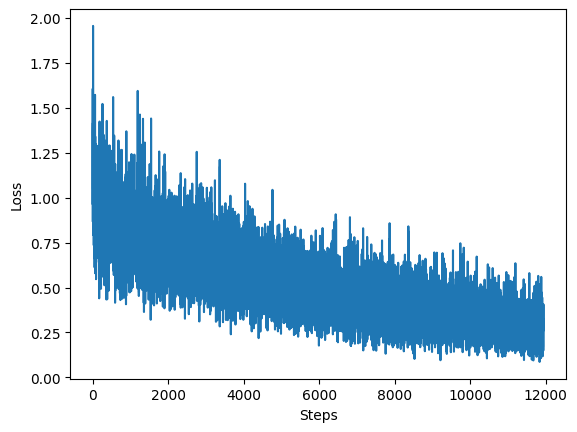

In [17]:
import matplotlib.pyplot as plt

plt.plot(losses, label='Training Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

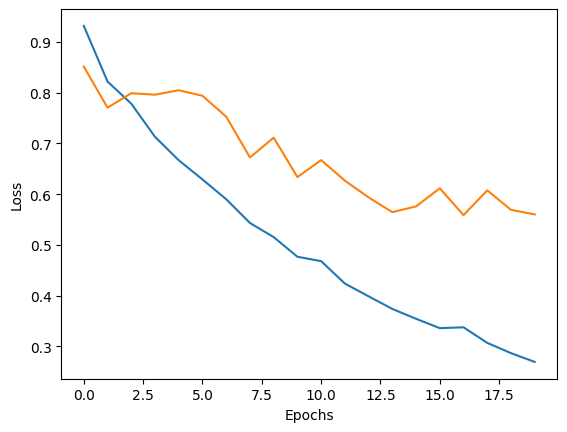

In [18]:
plt.plot(epoch_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Вот так и бывает
Сначала тужишься пыжишься с генерацией, а потом делаешь лабу с бертом с нуля за день. Я понимал с самого начала, что я могу это сделать, но мне было слишком скучно. Но то, что я сделал тупо задачу регрессии на берте - не признак того, что я сдался. Я обязательно сделаю "анекдотера", но уже в спокойной обстановке и когда будет побольше времени. 